In [1]:
%load_ext autoreload
%autoreload 2

In [59]:
import cv2
import matplotlib.pyplot as plt
import utils.utils_image as util
from models.SwinIR import SwinIR
from torch.utils.data import DataLoader
from einops import rearrange

import torch
from dataset.sr_dataset import DatasetSR
from utils.utils import calculate_psnr,calculate_ssim
import numpy as np


In [61]:
device= 'cuda:0' if torch.cuda.is_available() else 'cpu'
upscale = 4
window_size = 8
height = (1024 // upscale // window_size + 1) * window_size
width = (720 // upscale // window_size + 1) * window_size
train_dataset=DatasetSR(phase='train')
val_dataset=DatasetSR(phase='val')
train_dataloader=DataLoader(train_dataset,batch_size=16,num_workers=8,shuffle=True)
val_dataloader=DataLoader(val_dataset,batch_size=1,num_workers=1,shuffle=True)
import cv2

model = SwinIR(upscale=4,window_size=window_size, img_range=1., depths=[6, 6, 6, 6,6,6],
                embed_dim=180, num_heads=[6, 6, 6, 6,6,6], mlp_ratio=2, upsampler='pixelshuffle').to('cuda:0')


x = val_dataset[0]['L'].unsqueeze(0).to(device)
gt = val_dataset[0]['H']


model.eval()
with torch.no_grad():
    x=model(x)

x=x[0].cpu().numpy()
gt=gt.numpy()
x=rearrange(x,'b h w -> h w b')
gt=rearrange(gt,'c h w -> h w c')
x=(x*255).astype(np.uint8)
gt=(gt*255).astype(np.uint8)
print(x.shape)
print(gt.shape)
print(calculate_psnr(gt,x,crop_border=0))
print(calculate_ssim(gt,x,crop_border=0))

(1356, 2040, 3)
(1356, 2040, 3)
11.931076726802958
0.13409619175289442


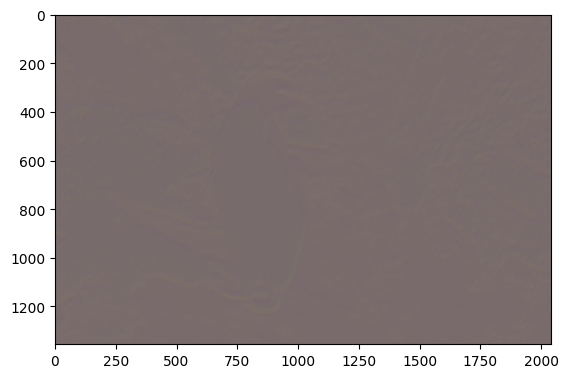

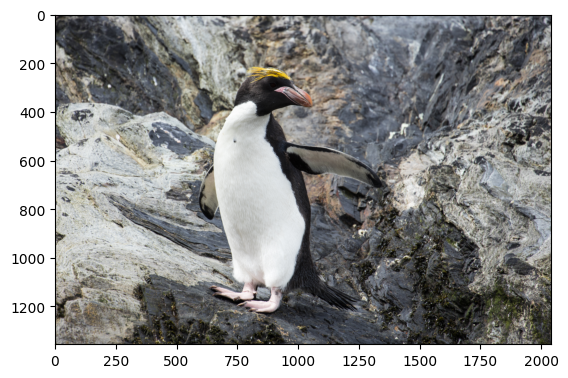

In [56]:
plt.imshow(x)
plt.show()
plt.imshow(gt)
plt.show()